In [73]:
import spikeinterface.full as si

In [76]:
import probeinterface
from pathlib import Path

base_dir = Path('/media/pierre/One Touch/groundtruth')

probe = probeinterface.read_prb(base_dir / 'mea_256.prb')
from pathlib import Path
from spikeinterface.sortingcomponents.peak_detection import detect_peaks



In [77]:
from spikeinterface.sortingcomponents.peak_detection import detect_peaks

In [78]:
def plot_juxta_amplitude(juxta_filename, peaks):
    juxta_sig = np.memmap(juxta_filename, dtype='float32')
    
    med = np.median(juxta_sig)
    mad = np.median(np.abs(juxta_sig-med))*1.4826
    thresh = med + 8*mad
    
    fig, axs = plt.subplots(nrows=2)

    count, bins = np.histogram(peaks['amplitude'], bins=np.arange(np.min(peaks['amplitude']), 0,  0.5))
    ax = axs[0]
    ax.plot(bins[:-1], count)
    ax.axvline(-thresh, color='r', ls='--')
    ax.axvline(med, color='k', ls='-')
    for i in range(1,6):
        ax.axvspan(med - i * mad, med + i * mad, color='k', alpha=0.05)
    
    fig.suptitle('juxta peak amplitude')
    
    ax = axs[1]
    ax.plot(peaks['sample_ind'], peaks['amplitude'], ls='None', marker='o')
    ax.axhline(-thresh, color='r', ls='--')
    for i in range(1,6):
        ax.axhspan(med - i * mad, med + i * mad, color='k', alpha=0.05)

detect peaks:   0%|          | 0/300 [00:00<?, ?it/s]

detect peaks:   0%|          | 0/300 [00:00<?, ?it/s]

detect peaks:   0%|          | 0/180 [00:00<?, ?it/s]

detect peaks:   0%|          | 0/202 [00:00<?, ?it/s]

detect peaks:   0%|          | 0/300 [00:00<?, ?it/s]

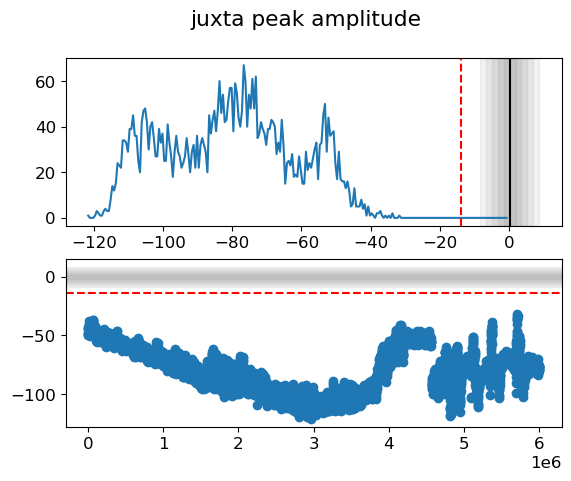

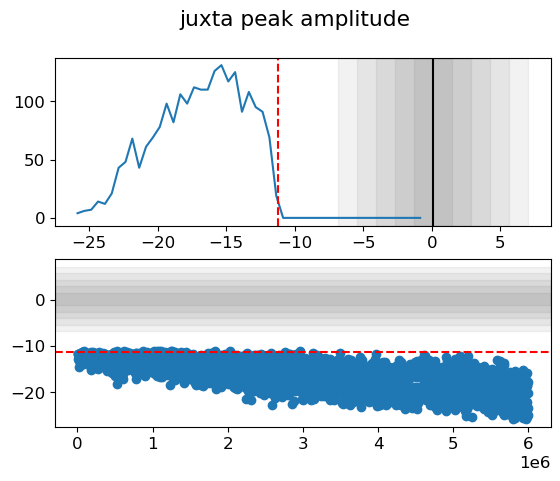

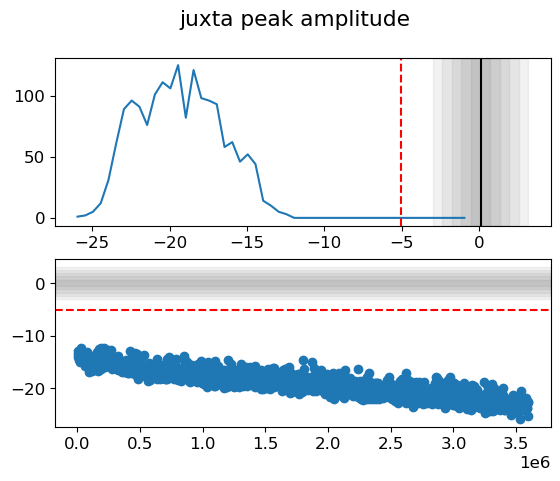

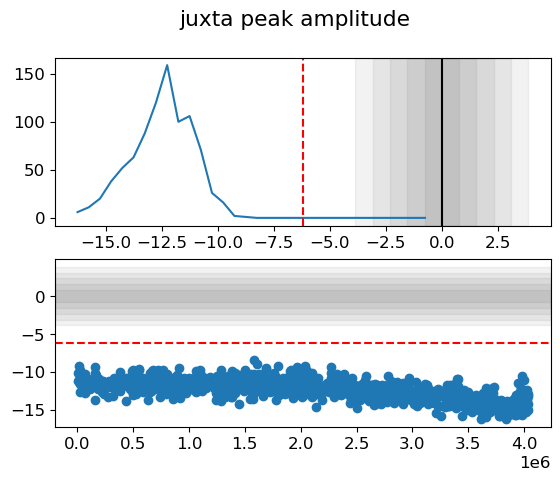

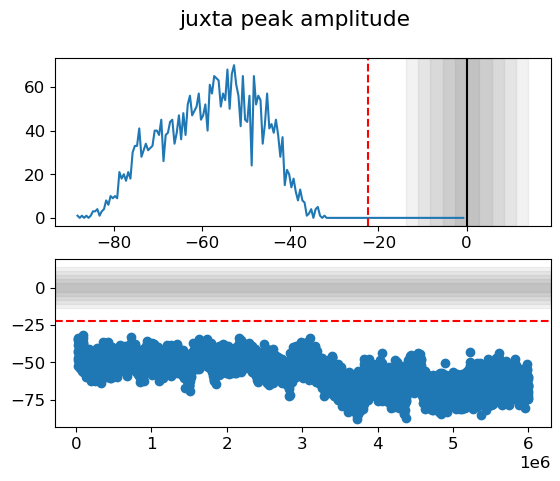

In [86]:
import os
recordings = {}
juxta = {}
peaks = {}
import numpy as np
import pylab as plt

for folder in os.listdir(base_dir / 'recordings'):
    file = base_dir / 'recordings' / folder / folder
    recording = si.read_mcsraw(str(file) + '.raw')
    recording.annotate(is_filtered=True)
    recording = recording.set_probegroup(probe)
    recordings[folder] = recording
    juxta[folder] = si.read_binary(str(file) + '.juxta.raw', sampling_frequency=20000, num_chan=1, dtype='float32')
    peaks[folder] = detect_peaks(juxta[folder], exclude_sweep_ms=2, detect_threshold=8)
    plot_juxta_amplitude(str(file) + '.juxta.raw', peaks[folder])

In [87]:
waveforms = {}
for folder in os.listdir(base_dir / 'recordings'):
    file = base_dir / 'waveforms' / folder
    times = peaks[folder]['sample_ind']
    sorting = si.NumpySorting.from_times_labels(times, np.zeros(len(times)), sampling_frequency=20000)
    waveforms[folder] = si.extract_waveforms(recordings[folder], sorting, folder=file, n_jobs=-1, overwrite=True, chunk_memory="10M")

/home/pierre/github/spikeinterface/spikeinterface/core/waveform_extractor.py:259: UserWarning: Sorting object is not dumpable, which might result in downstream errors for parallel processing. To make the sorting dumpable, use the `sorting.save()` function.
  warn("Sorting object is not dumpable, which might result in downstream errors for "


extract waveforms memmap:   0%|          | 0/303 [00:00<?, ?it/s]

extract waveforms memmap:   0%|          | 0/303 [00:00<?, ?it/s]

extract waveforms memmap:   0%|          | 0/182 [00:00<?, ?it/s]

extract waveforms memmap:   0%|          | 0/204 [00:00<?, ?it/s]

extract waveforms memmap:   0%|          | 0/303 [00:00<?, ?it/s]

In [88]:
channel_positions = recordings['20160415_patch2'].get_channel_locations()
#real_positions = {'20160426_patch3' : channel_positions[226] + [0, -10],
#                  '20170726_patch1' : (0.9*channel_positions[30] + 0.1*channel_positions[3] + [5, 0]),
#                  '20170728_patch2' : channel_positions[118] + [0, 5],
#                  '20160426_patch2' : channel_positions[200] + [-15, -15], 
#                  '20160415_patch2' : (channel_positions[69] + channel_positions[33])/2.}

real_positions = {'20160426_patch3' : channel_positions[226] + [2, -5],
                  '20170726_patch1' : channel_positions[30] + [6,6],
                  '20170728_patch2' : channel_positions[118] + [-2,9],
                  '20160426_patch2' : channel_positions[200] + [-18, -12], 
                  '20160415_patch2' : channel_positions[69] +  [3,-15]}

In [89]:
%matplotlib inline

unit_positions = {}
spikes_positions = {}

import matplotlib.image as mpimg

for folder in  os.listdir(base_dir / 'recordings'):
    unit_positions[folder] = {}
    spikes_positions[folder] = {}
    for method in ['center_of_mass', 'monopolar_triangulation']:
        if method == 'center_of_mass':
            for feature in ['ptp', 'energy', 'v_peak']:
                title = f'CoM ({feature})'
                params = {'feature' : feature, 'local_radius_um' : 50}
                
                unit_positions[folder][title] = si.compute_unit_locations(waveforms[folder], method=method, 
                                                            **params)
                spikes_positions[folder][title] = si.compute_spike_locations(waveforms[folder], method=method, 
                                                                          method_kwargs=params, n_jobs=-1,
                                                                        chunk_memory="10M", outputs='by_unit')
                
        elif method == 'monopolar_triangulation':
            title = f'Monopolar'
            params = {'enforce_decrease': True, 'local_radius_um' : 50}
        
            unit_positions[folder][title] = si.compute_unit_locations(waveforms[folder], method=method, 
                                                            **params)
            
            spikes_positions[folder][title] = si.compute_spike_locations(waveforms[folder], method=method, 
                                                                          method_kwargs=params, n_jobs=-1,
                                                                        chunk_memory="10M", outputs='by_unit')

localize peaks:   0%|          | 0/303 [00:00<?, ?it/s]

/home/pierre/github/spikeinterface/spikeinterface/sortingcomponents/peak_localization.py:142: RuntimeWarning: invalid value encountered in true_divide
  
/home/pierre/github/spikeinterface/spikeinterface/sortingcomponents/peak_localization.py:142: RuntimeWarning: invalid value encountered in true_divide
  
/home/pierre/github/spikeinterface/spikeinterface/sortingcomponents/peak_localization.py:142: RuntimeWarning: invalid value encountered in true_divide
  
/home/pierre/github/spikeinterface/spikeinterface/sortingcomponents/peak_localization.py:142: RuntimeWarning: invalid value encountered in true_divide
  
/home/pierre/github/spikeinterface/spikeinterface/sortingcomponents/peak_localization.py:142: RuntimeWarning: invalid value encountered in true_divide
  
/home/pierre/github/spikeinterface/spikeinterface/sortingcomponents/peak_localization.py:142: RuntimeWarning: invalid value encountered in true_divide
  
/home/pierre/github/spikeinterface/spikeinterface/sortingcomponents/peak_loc

localize peaks:   0%|          | 0/303 [00:00<?, ?it/s]

/home/pierre/github/spikeinterface/spikeinterface/sortingcomponents/peak_localization.py:142: RuntimeWarning: invalid value encountered in true_divide
  
/home/pierre/github/spikeinterface/spikeinterface/sortingcomponents/peak_localization.py:142: RuntimeWarning: invalid value encountered in true_divide
  
/home/pierre/github/spikeinterface/spikeinterface/sortingcomponents/peak_localization.py:142: RuntimeWarning: invalid value encountered in true_divide
  
/home/pierre/github/spikeinterface/spikeinterface/sortingcomponents/peak_localization.py:142: RuntimeWarning: invalid value encountered in true_divide
  
/home/pierre/github/spikeinterface/spikeinterface/sortingcomponents/peak_localization.py:142: RuntimeWarning: invalid value encountered in true_divide
  
/home/pierre/github/spikeinterface/spikeinterface/sortingcomponents/peak_localization.py:142: RuntimeWarning: invalid value encountered in true_divide
  
/home/pierre/github/spikeinterface/spikeinterface/sortingcomponents/peak_loc

localize peaks:   0%|          | 0/303 [00:00<?, ?it/s]

/home/pierre/github/spikeinterface/spikeinterface/sortingcomponents/peak_localization.py:142: RuntimeWarning: invalid value encountered in true_divide
  
/home/pierre/github/spikeinterface/spikeinterface/sortingcomponents/peak_localization.py:142: RuntimeWarning: invalid value encountered in true_divide
  
/home/pierre/github/spikeinterface/spikeinterface/sortingcomponents/peak_localization.py:142: RuntimeWarning: invalid value encountered in true_divide
  
/home/pierre/github/spikeinterface/spikeinterface/sortingcomponents/peak_localization.py:142: RuntimeWarning: invalid value encountered in true_divide
  
/home/pierre/github/spikeinterface/spikeinterface/sortingcomponents/peak_localization.py:142: RuntimeWarning: invalid value encountered in true_divide
  
/home/pierre/github/spikeinterface/spikeinterface/sortingcomponents/peak_localization.py:142: RuntimeWarning: invalid value encountered in true_divide
  
/home/pierre/github/spikeinterface/spikeinterface/sortingcomponents/peak_loc

localize peaks:   0%|          | 0/303 [00:00<?, ?it/s]

/home/pierre/github/spikeinterface/spikeinterface/postprocessing/unit_localization.py:148: RuntimeWarning: invalid value encountered in true_divide
  com = np.sum(wf_ptp[:, np.newaxis] * local_contact_locations, axis=0) / np.sum(wf_ptp)
/home/pierre/github/spikeinterface/spikeinterface/postprocessing/unit_localization.py:219: RuntimeWarning: invalid value encountered in true_divide
  err = np.square(wf_ptp / maxptp - ptp_at(x, y, z, alpha, local_contact_locations)).mean() - np.log1p(10.0 * z) / 10000.0
/home/pierre/github/spikeinterface/spikeinterface/postprocessing/unit_localization.py:148: RuntimeWarning: invalid value encountered in true_divide
  com = np.sum(wf_ptp[:, np.newaxis] * local_contact_locations, axis=0) / np.sum(wf_ptp)
/home/pierre/github/spikeinterface/spikeinterface/postprocessing/unit_localization.py:219: RuntimeWarning: invalid value encountered in true_divide
  err = np.square(wf_ptp / maxptp - ptp_at(x, y, z, alpha, local_contact_locations)).mean() - np.log1p(10.0

localize peaks:   0%|          | 0/303 [00:00<?, ?it/s]

/home/pierre/github/spikeinterface/spikeinterface/sortingcomponents/peak_localization.py:142: RuntimeWarning: invalid value encountered in true_divide
  
/home/pierre/github/spikeinterface/spikeinterface/sortingcomponents/peak_localization.py:142: RuntimeWarning: invalid value encountered in true_divide
  
/home/pierre/github/spikeinterface/spikeinterface/sortingcomponents/peak_localization.py:142: RuntimeWarning: invalid value encountered in true_divide
  
/home/pierre/github/spikeinterface/spikeinterface/sortingcomponents/peak_localization.py:142: RuntimeWarning: invalid value encountered in true_divide
  
/home/pierre/github/spikeinterface/spikeinterface/sortingcomponents/peak_localization.py:142: RuntimeWarning: invalid value encountered in true_divide
  
/home/pierre/github/spikeinterface/spikeinterface/sortingcomponents/peak_localization.py:142: RuntimeWarning: invalid value encountered in true_divide
  
/home/pierre/github/spikeinterface/spikeinterface/sortingcomponents/peak_loc

localize peaks:   0%|          | 0/303 [00:00<?, ?it/s]

/home/pierre/github/spikeinterface/spikeinterface/sortingcomponents/peak_localization.py:142: RuntimeWarning: invalid value encountered in true_divide
  
/home/pierre/github/spikeinterface/spikeinterface/sortingcomponents/peak_localization.py:142: RuntimeWarning: invalid value encountered in true_divide
  
/home/pierre/github/spikeinterface/spikeinterface/sortingcomponents/peak_localization.py:142: RuntimeWarning: invalid value encountered in true_divide
  
/home/pierre/github/spikeinterface/spikeinterface/sortingcomponents/peak_localization.py:142: RuntimeWarning: invalid value encountered in true_divide
  
/home/pierre/github/spikeinterface/spikeinterface/sortingcomponents/peak_localization.py:142: RuntimeWarning: invalid value encountered in true_divide
  
/home/pierre/github/spikeinterface/spikeinterface/sortingcomponents/peak_localization.py:142: RuntimeWarning: invalid value encountered in true_divide
  


localize peaks:   0%|          | 0/303 [00:00<?, ?it/s]

/home/pierre/github/spikeinterface/spikeinterface/sortingcomponents/peak_localization.py:142: RuntimeWarning: invalid value encountered in true_divide
  
/home/pierre/github/spikeinterface/spikeinterface/sortingcomponents/peak_localization.py:142: RuntimeWarning: invalid value encountered in true_divide
  
/home/pierre/github/spikeinterface/spikeinterface/sortingcomponents/peak_localization.py:142: RuntimeWarning: invalid value encountered in true_divide
  
/home/pierre/github/spikeinterface/spikeinterface/sortingcomponents/peak_localization.py:142: RuntimeWarning: invalid value encountered in true_divide
  
/home/pierre/github/spikeinterface/spikeinterface/sortingcomponents/peak_localization.py:142: RuntimeWarning: invalid value encountered in true_divide
  


localize peaks:   0%|          | 0/303 [00:00<?, ?it/s]

/home/pierre/github/spikeinterface/spikeinterface/postprocessing/unit_localization.py:148: RuntimeWarning: invalid value encountered in true_divide
  com = np.sum(wf_ptp[:, np.newaxis] * local_contact_locations, axis=0) / np.sum(wf_ptp)
/home/pierre/github/spikeinterface/spikeinterface/postprocessing/unit_localization.py:219: RuntimeWarning: invalid value encountered in true_divide
  err = np.square(wf_ptp / maxptp - ptp_at(x, y, z, alpha, local_contact_locations)).mean() - np.log1p(10.0 * z) / 10000.0
/home/pierre/github/spikeinterface/spikeinterface/postprocessing/unit_localization.py:148: RuntimeWarning: invalid value encountered in true_divide
  com = np.sum(wf_ptp[:, np.newaxis] * local_contact_locations, axis=0) / np.sum(wf_ptp)
/home/pierre/github/spikeinterface/spikeinterface/postprocessing/unit_localization.py:219: RuntimeWarning: invalid value encountered in true_divide
  err = np.square(wf_ptp / maxptp - ptp_at(x, y, z, alpha, local_contact_locations)).mean() - np.log1p(10.0

localize peaks:   0%|          | 0/182 [00:00<?, ?it/s]

/home/pierre/github/spikeinterface/spikeinterface/sortingcomponents/peak_localization.py:142: RuntimeWarning: invalid value encountered in true_divide
  
/home/pierre/github/spikeinterface/spikeinterface/sortingcomponents/peak_localization.py:142: RuntimeWarning: invalid value encountered in true_divide
  
/home/pierre/github/spikeinterface/spikeinterface/sortingcomponents/peak_localization.py:142: RuntimeWarning: invalid value encountered in true_divide
  
/home/pierre/github/spikeinterface/spikeinterface/sortingcomponents/peak_localization.py:142: RuntimeWarning: invalid value encountered in true_divide
  
/home/pierre/github/spikeinterface/spikeinterface/sortingcomponents/peak_localization.py:142: RuntimeWarning: invalid value encountered in true_divide
  
/home/pierre/github/spikeinterface/spikeinterface/sortingcomponents/peak_localization.py:142: RuntimeWarning: invalid value encountered in true_divide
  
/home/pierre/github/spikeinterface/spikeinterface/sortingcomponents/peak_loc

localize peaks:   0%|          | 0/182 [00:00<?, ?it/s]

/home/pierre/github/spikeinterface/spikeinterface/sortingcomponents/peak_localization.py:142: RuntimeWarning: invalid value encountered in true_divide
  
/home/pierre/github/spikeinterface/spikeinterface/sortingcomponents/peak_localization.py:142: RuntimeWarning: invalid value encountered in true_divide
  
/home/pierre/github/spikeinterface/spikeinterface/sortingcomponents/peak_localization.py:142: RuntimeWarning: invalid value encountered in true_divide
  
/home/pierre/github/spikeinterface/spikeinterface/sortingcomponents/peak_localization.py:142: RuntimeWarning: invalid value encountered in true_divide
  
/home/pierre/github/spikeinterface/spikeinterface/sortingcomponents/peak_localization.py:142: RuntimeWarning: invalid value encountered in true_divide
  
/home/pierre/github/spikeinterface/spikeinterface/sortingcomponents/peak_localization.py:142: RuntimeWarning: invalid value encountered in true_divide
  


localize peaks:   0%|          | 0/182 [00:00<?, ?it/s]

/home/pierre/github/spikeinterface/spikeinterface/sortingcomponents/peak_localization.py:142: RuntimeWarning: invalid value encountered in true_divide
  
/home/pierre/github/spikeinterface/spikeinterface/sortingcomponents/peak_localization.py:142: RuntimeWarning: invalid value encountered in true_divide
  
/home/pierre/github/spikeinterface/spikeinterface/sortingcomponents/peak_localization.py:142: RuntimeWarning: invalid value encountered in true_divide
  
/home/pierre/github/spikeinterface/spikeinterface/sortingcomponents/peak_localization.py:142: RuntimeWarning: invalid value encountered in true_divide
  
/home/pierre/github/spikeinterface/spikeinterface/sortingcomponents/peak_localization.py:142: RuntimeWarning: invalid value encountered in true_divide
  
/home/pierre/github/spikeinterface/spikeinterface/sortingcomponents/peak_localization.py:142: RuntimeWarning: invalid value encountered in true_divide
  


localize peaks:   0%|          | 0/182 [00:00<?, ?it/s]

/home/pierre/github/spikeinterface/spikeinterface/postprocessing/unit_localization.py:148: RuntimeWarning: invalid value encountered in true_divide
  com = np.sum(wf_ptp[:, np.newaxis] * local_contact_locations, axis=0) / np.sum(wf_ptp)
/home/pierre/github/spikeinterface/spikeinterface/postprocessing/unit_localization.py:219: RuntimeWarning: invalid value encountered in true_divide
  err = np.square(wf_ptp / maxptp - ptp_at(x, y, z, alpha, local_contact_locations)).mean() - np.log1p(10.0 * z) / 10000.0
/home/pierre/github/spikeinterface/spikeinterface/postprocessing/unit_localization.py:148: RuntimeWarning: invalid value encountered in true_divide
  com = np.sum(wf_ptp[:, np.newaxis] * local_contact_locations, axis=0) / np.sum(wf_ptp)
/home/pierre/github/spikeinterface/spikeinterface/postprocessing/unit_localization.py:219: RuntimeWarning: invalid value encountered in true_divide
  err = np.square(wf_ptp / maxptp - ptp_at(x, y, z, alpha, local_contact_locations)).mean() - np.log1p(10.0

localize peaks:   0%|          | 0/204 [00:00<?, ?it/s]

/home/pierre/github/spikeinterface/spikeinterface/sortingcomponents/peak_localization.py:142: RuntimeWarning: invalid value encountered in true_divide
  
/home/pierre/github/spikeinterface/spikeinterface/sortingcomponents/peak_localization.py:142: RuntimeWarning: invalid value encountered in true_divide
  
/home/pierre/github/spikeinterface/spikeinterface/sortingcomponents/peak_localization.py:142: RuntimeWarning: invalid value encountered in true_divide
  
/home/pierre/github/spikeinterface/spikeinterface/sortingcomponents/peak_localization.py:142: RuntimeWarning: invalid value encountered in true_divide
  
/home/pierre/github/spikeinterface/spikeinterface/sortingcomponents/peak_localization.py:142: RuntimeWarning: invalid value encountered in true_divide
  
/home/pierre/github/spikeinterface/spikeinterface/sortingcomponents/peak_localization.py:142: RuntimeWarning: invalid value encountered in true_divide
  
/home/pierre/github/spikeinterface/spikeinterface/sortingcomponents/peak_loc

localize peaks:   0%|          | 0/204 [00:00<?, ?it/s]

/home/pierre/github/spikeinterface/spikeinterface/sortingcomponents/peak_localization.py:142: RuntimeWarning: invalid value encountered in true_divide
  
/home/pierre/github/spikeinterface/spikeinterface/sortingcomponents/peak_localization.py:142: RuntimeWarning: invalid value encountered in true_divide
  
/home/pierre/github/spikeinterface/spikeinterface/sortingcomponents/peak_localization.py:142: RuntimeWarning: invalid value encountered in true_divide
  
/home/pierre/github/spikeinterface/spikeinterface/sortingcomponents/peak_localization.py:142: RuntimeWarning: invalid value encountered in true_divide
  
/home/pierre/github/spikeinterface/spikeinterface/sortingcomponents/peak_localization.py:142: RuntimeWarning: invalid value encountered in true_divide
  
/home/pierre/github/spikeinterface/spikeinterface/sortingcomponents/peak_localization.py:142: RuntimeWarning: invalid value encountered in true_divide
  


localize peaks:   0%|          | 0/204 [00:00<?, ?it/s]

/home/pierre/github/spikeinterface/spikeinterface/sortingcomponents/peak_localization.py:142: RuntimeWarning: invalid value encountered in true_divide
  
/home/pierre/github/spikeinterface/spikeinterface/sortingcomponents/peak_localization.py:142: RuntimeWarning: invalid value encountered in true_divide
  
/home/pierre/github/spikeinterface/spikeinterface/sortingcomponents/peak_localization.py:142: RuntimeWarning: invalid value encountered in true_divide
  
/home/pierre/github/spikeinterface/spikeinterface/sortingcomponents/peak_localization.py:142: RuntimeWarning: invalid value encountered in true_divide
  
/home/pierre/github/spikeinterface/spikeinterface/sortingcomponents/peak_localization.py:142: RuntimeWarning: invalid value encountered in true_divide
  


localize peaks:   0%|          | 0/204 [00:00<?, ?it/s]

/home/pierre/github/spikeinterface/spikeinterface/postprocessing/unit_localization.py:148: RuntimeWarning: invalid value encountered in true_divide
  com = np.sum(wf_ptp[:, np.newaxis] * local_contact_locations, axis=0) / np.sum(wf_ptp)
/home/pierre/github/spikeinterface/spikeinterface/postprocessing/unit_localization.py:219: RuntimeWarning: invalid value encountered in true_divide
  err = np.square(wf_ptp / maxptp - ptp_at(x, y, z, alpha, local_contact_locations)).mean() - np.log1p(10.0 * z) / 10000.0
/home/pierre/github/spikeinterface/spikeinterface/postprocessing/unit_localization.py:148: RuntimeWarning: invalid value encountered in true_divide
  com = np.sum(wf_ptp[:, np.newaxis] * local_contact_locations, axis=0) / np.sum(wf_ptp)
/home/pierre/github/spikeinterface/spikeinterface/postprocessing/unit_localization.py:219: RuntimeWarning: invalid value encountered in true_divide
  err = np.square(wf_ptp / maxptp - ptp_at(x, y, z, alpha, local_contact_locations)).mean() - np.log1p(10.0

localize peaks:   0%|          | 0/303 [00:00<?, ?it/s]

/home/pierre/github/spikeinterface/spikeinterface/sortingcomponents/peak_localization.py:142: RuntimeWarning: invalid value encountered in true_divide
  
/home/pierre/github/spikeinterface/spikeinterface/sortingcomponents/peak_localization.py:142: RuntimeWarning: invalid value encountered in true_divide
  
/home/pierre/github/spikeinterface/spikeinterface/sortingcomponents/peak_localization.py:142: RuntimeWarning: invalid value encountered in true_divide
  
/home/pierre/github/spikeinterface/spikeinterface/sortingcomponents/peak_localization.py:142: RuntimeWarning: invalid value encountered in true_divide
  
/home/pierre/github/spikeinterface/spikeinterface/sortingcomponents/peak_localization.py:142: RuntimeWarning: invalid value encountered in true_divide
  
/home/pierre/github/spikeinterface/spikeinterface/sortingcomponents/peak_localization.py:142: RuntimeWarning: invalid value encountered in true_divide
  
/home/pierre/github/spikeinterface/spikeinterface/sortingcomponents/peak_loc

localize peaks:   0%|          | 0/303 [00:00<?, ?it/s]

/home/pierre/github/spikeinterface/spikeinterface/sortingcomponents/peak_localization.py:142: RuntimeWarning: invalid value encountered in true_divide
  
/home/pierre/github/spikeinterface/spikeinterface/sortingcomponents/peak_localization.py:142: RuntimeWarning: invalid value encountered in true_divide
  
/home/pierre/github/spikeinterface/spikeinterface/sortingcomponents/peak_localization.py:142: RuntimeWarning: invalid value encountered in true_divide
  
/home/pierre/github/spikeinterface/spikeinterface/sortingcomponents/peak_localization.py:142: RuntimeWarning: invalid value encountered in true_divide
  
/home/pierre/github/spikeinterface/spikeinterface/sortingcomponents/peak_localization.py:142: RuntimeWarning: invalid value encountered in true_divide
  
/home/pierre/github/spikeinterface/spikeinterface/sortingcomponents/peak_localization.py:142: RuntimeWarning: invalid value encountered in true_divide
  
/home/pierre/github/spikeinterface/spikeinterface/sortingcomponents/peak_loc

localize peaks:   0%|          | 0/303 [00:00<?, ?it/s]

/home/pierre/github/spikeinterface/spikeinterface/sortingcomponents/peak_localization.py:142: RuntimeWarning: invalid value encountered in true_divide
  
/home/pierre/github/spikeinterface/spikeinterface/sortingcomponents/peak_localization.py:142: RuntimeWarning: invalid value encountered in true_divide
  
/home/pierre/github/spikeinterface/spikeinterface/sortingcomponents/peak_localization.py:142: RuntimeWarning: invalid value encountered in true_divide
  
/home/pierre/github/spikeinterface/spikeinterface/sortingcomponents/peak_localization.py:142: RuntimeWarning: invalid value encountered in true_divide
  
/home/pierre/github/spikeinterface/spikeinterface/sortingcomponents/peak_localization.py:142: RuntimeWarning: invalid value encountered in true_divide
  
/home/pierre/github/spikeinterface/spikeinterface/sortingcomponents/peak_localization.py:142: RuntimeWarning: invalid value encountered in true_divide
  
/home/pierre/github/spikeinterface/spikeinterface/sortingcomponents/peak_loc

localize peaks:   0%|          | 0/303 [00:00<?, ?it/s]

/home/pierre/github/spikeinterface/spikeinterface/postprocessing/unit_localization.py:148: RuntimeWarning: invalid value encountered in true_divide
  com = np.sum(wf_ptp[:, np.newaxis] * local_contact_locations, axis=0) / np.sum(wf_ptp)
/home/pierre/github/spikeinterface/spikeinterface/postprocessing/unit_localization.py:219: RuntimeWarning: invalid value encountered in true_divide
  err = np.square(wf_ptp / maxptp - ptp_at(x, y, z, alpha, local_contact_locations)).mean() - np.log1p(10.0 * z) / 10000.0
/home/pierre/github/spikeinterface/spikeinterface/postprocessing/unit_localization.py:148: RuntimeWarning: invalid value encountered in true_divide
  com = np.sum(wf_ptp[:, np.newaxis] * local_contact_locations, axis=0) / np.sum(wf_ptp)
/home/pierre/github/spikeinterface/spikeinterface/postprocessing/unit_localization.py:219: RuntimeWarning: invalid value encountered in true_divide
  err = np.square(wf_ptp / maxptp - ptp_at(x, y, z, alpha, local_contact_locations)).mean() - np.log1p(10.0

FileNotFoundError: [Errno 2] No such file or directory: '/media/pierre/One Touch/groundtruth/recordings/20170728_patch2/20170728_patch2.jpg'

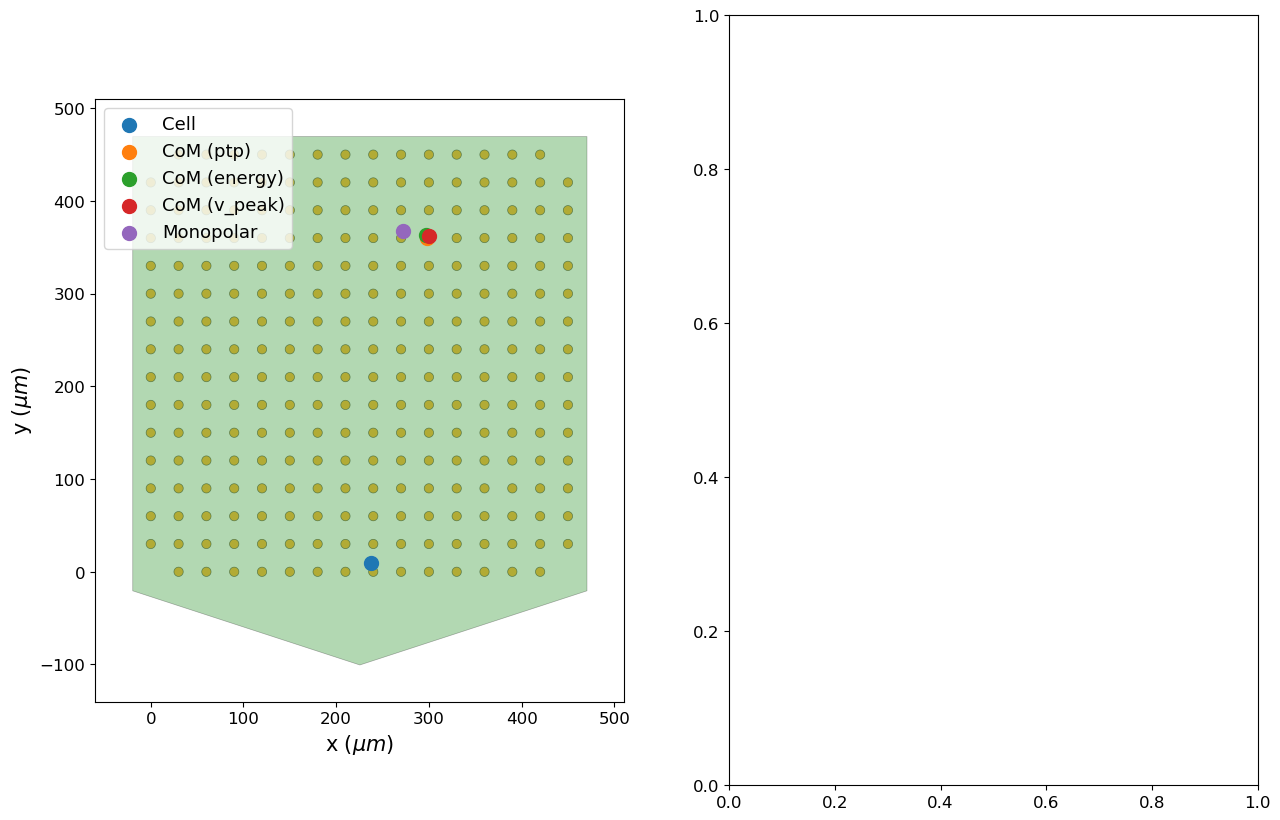

In [90]:
%matplotlib inline

import matplotlib.image as mpimg

for folder in  os.listdir(base_dir / 'recordings'):
    fig, axes = plt.subplots(1, 2, figsize=(15, 10))
    
    si.plot_probe_map(recording, ax=axes[0])
    
    #count = 0
    #for key, value in spikes_positions[folder].items():
    #    axes[0].scatter(value[0][0.0]['x'], value[0][0.0]['y'], alpha=0.01, c=f'C{count}')
    #    count += 1
        
    axes[0].scatter([real_positions[folder][0]], [real_positions[folder][1]], s=100, label='Cell')
    for key, value in unit_positions[folder].items(): 
        axes[0].scatter([value[0][0]], [value[0][1]], s=100, label=key)
    
    axes[0].legend()
    
    file = base_dir / 'recordings' / folder / folder
    img = mpimg.imread(f'{file}.jpg')
    imgplot = axes[1].imshow(img, aspect='auto')
    axes[1].set_xticks([])
    axes[1].set_yticks([])
    axes[0].set_title(folder)

In [91]:
def _simpleaxis(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()


In [92]:
res_unit = {}
res_spikes = {}
for folder in real_positions.keys():
    for key in unit_positions[folder].keys():
        if key not in res_unit:
            res_unit[key] = []
            res_spikes[key] = []
        res_unit[key] += [np.linalg.norm(real_positions[folder] - unit_positions[folder][key][0, :2])]
        
        data = spikes_positions[folder][key][0][0.0]
        errors = np.sqrt((data['x'] - real_positions[folder][0])**2 + (data['y'] - real_positions[folder][1])**2)
        res_spikes[key] += list(errors)


FileNotFoundError: [Errno 2] No such file or directory: '/media/pierre/One Touch/groundtruth/recordings/20160415_patch2/20160415_patch2.jpg'

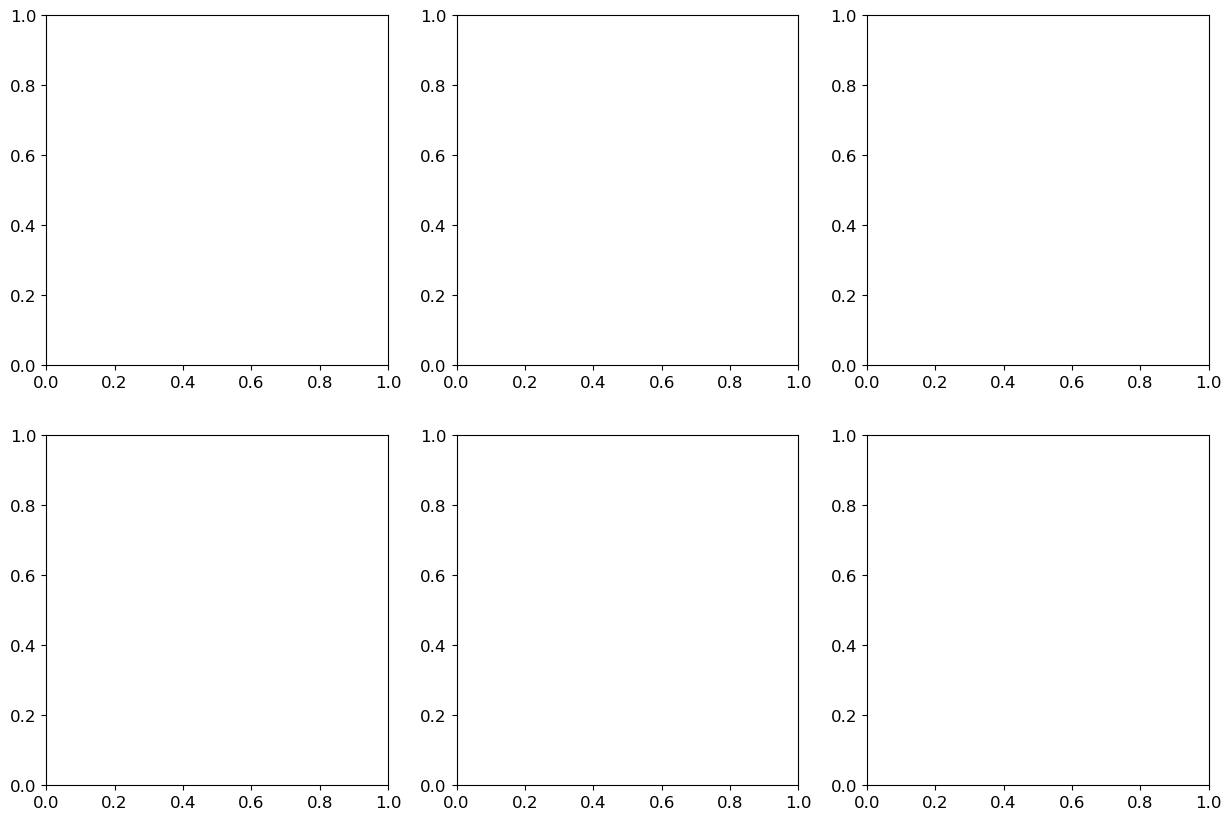

In [93]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
plt.rc('font', size=13)
plt.rc('xtick', labelsize=12) 
plt.rc('ytick', labelsize=12) 

file = base_dir / 'recordings' / '20160415_patch2' / '20160415_patch2'
img = mpimg.imread(f'{file}.jpg')
imgplot = axes[0, 0].imshow(img, aspect='auto')
axes[0, 0].set_xticks([])
axes[0, 0].set_yticks([])

#axes[0, 2].scatter([real_positions[folder][0]], [real_positions[folder][1]], s=100, label='Cell')
for key, value in unit_positions[folder].items(): 
    axes[0, 2].scatter([value[0][0]], [value[0][1]], s=100, label=key)
axes[0, 2].legend()
si.plot_probe_map(recording, ax=axes[0, 2])
axes[0, 2].set_xlim(250, 500)
axes[0, 2].set_ylim(175, 500)
axes[0, 2].set_xticks([])
axes[0, 2].set_yticks([])
axes[0, 2].set_xlabel('')
axes[0, 2].set_ylabel('')

for count, value in enumerate(res_unit.values()):
    axes[1, 0].violinplot(value, [count], showmeans=True)

si.plot_unit_templates(waveforms['20160415_patch2'], ax=axes[0, 1], same_axis=True, unit_colors={0 : 'k'})
axes[0, 1].set_xlim(225, 500)
axes[0, 1].set_ylim(175, 500)
_simpleaxis(axes[0, 1])
_simpleaxis(axes[0, 2])
axes[0, 1].set_xticks([])
axes[0, 1].set_yticks([])
axes[0, 1].set_xlabel('')
axes[0, 1].set_ylabel('')
for ax in [axes[0, 1], axes[0, 2]]:
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)

    
_simpleaxis(axes[1, 0])
axes[1, 0].set_xticks(np.arange(len(res_unit.keys())), res_unit.keys(), rotation=45)
axes[1, 0].set_ylabel('error (um)')
axes[1, 0].set_title('Averaged template')
axes[1, 0].set_ylim(0.1, 100)
axes[1, 0].set_yscale('log')
axes[1, 0].plot([-0.5, len(res_unit.keys())], [10, 10], 'k--')


for count, value in enumerate(res_spikes.values()):
    axes[1, 1].violinplot(value, [count], showmeans=True)

axes[1, 1].set_yscale('log')
_simpleaxis(axes[1, 1])
axes[1, 1].set_xticks(np.arange(len(res_unit.keys())), res_unit.keys(), rotation=45)
axes[1, 1].set_ylabel('error (um)')
axes[1, 1].set_title('Single spikes')
axes[1, 1].set_ylim(0.1, 100)
axes[1, 1].set_yscale('log')
axes[1, 1].plot([-0.5, len(res_unit.keys())], [10, 10], 'k--')

res = []
for folder in real_positions.keys():
    res += [si.compute_snrs(waveforms[folder])[0.0]]

idx = np.argsort(res)
res = np.array(res)

for key in res_unit.keys():
    axes[1, 2].plot(res[idx], np.array(res_unit[key])[idx])    
_simpleaxis(axes[1, 2])
axes[1, 2].set_xlabel('snr (dB)')
axes[1, 2].set_ylabel('error (um)')
    
plt.savefig('gt.pdf')


In [59]:
res = []
for key, w in waveforms.items():
    res += [si.compute_snrs(w)[0.0]]


In [61]:
res_unit

{'CoM (ptp)': [18.771816525788292,
  10.838066713697208,
  5.309131503222444,
  17.692186977432872,
  11.03996350013079],
 'CoM (energy)': [18.783129228201012,
  12.129742006451032,
  5.30526824115089,
  18.552965478200267,
  11.09152958106676],
 'CoM (v_peak)': [15.01035645187047,
  11.363284279648825,
  5.052419599753687,
  20.310545010550875,
  8.279004014206507],
 'Monopolar': [14.711607468939107,
  11.68853921800094,
  1.7609967001062674,
  21.141678143838497,
  9.139300001201448]}

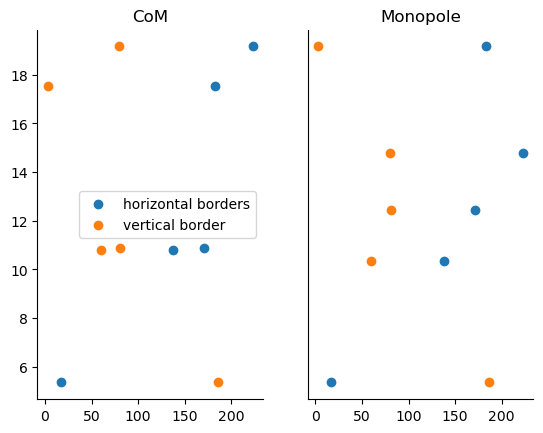

In [48]:
xdist = []
ydist = []
for key in real_positions.keys():
    xdist += [real_positions[key][0]]
    ydist += [real_positions[key][1]]

fig, ax = plt.subplots(1, 2) 
ax[0].scatter(np.abs(450//2 - np.array(xdist)), res['com'], label='horizontal borders')
ax[0].scatter(np.abs(450//2 - np.array(ydist)), res['com'], label='vertical border')
ax[1].set_yticks([])
_simpleaxis(ax[0])
ax[1].set_title('Monopole')
ax[0].set_title('CoM')
ax[0].legend()


ax[1].scatter(np.abs(450//2 - np.array(xdist)), res['mon'])
ax[1].scatter(np.abs(450//2 - np.array(ydist)), res['mon'])
_simpleaxis(ax[1])
